# Omniglot 20-way One-shot Learning
## Using a Siamese CNN to perform 20-way one-shot classification on 20 alphabets from the Omniglot data
### Constantin Baumgartner 11/18/2018

## Introduction

Well-trained deep learning models can approach and surpass human-level performance on tasks like image recognition ([Onychomycosis Diagnosis](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191493)) and playing video games ([Dota-2](https://blog.openai.com/dota-2/), [Quake III Arena Capture the Flag](https://arxiv.org/abs/1807.01281)). One of the reasons deep learning models can achieve this human-level performance is due to the ubiquitous availability of large amounts of digital data. While deep learning is well suited for these data-rich applications, it tends to suffer from poor generalization in situations where not enough data is available to properly tune the millions of parameters in a deep learning model.

One-shot learning, the task of learning to identify and distinguish between categories using only one or very few training samples, is an area where humans still outperform deep learning models. The human ability to generalize structures, concepts, and ideas from a very small number of samples is something that eludes most deep learning model architectures. The Siamese neural network architecture, however, is able to generalize well to certain one-shot classification tasks involving sparse amounts of data.

In the following analysis we make use of a Siamese neural net to perform 20-way one-shot classification using the [Omniglot data](https://github.com/brendenlake/omniglot). We first explain the relevant concepts, namely the Siamese neural net architecture and 20-way one-shot learning, followed by an analysis of our data, and finally attempt to replicate the Siamese neural net used in the [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) paper to perform 20-way one shot learning on an evaluation subset of the Omniglot data. The final model achieves an average accuracy of 69.0% across 400 20-way one-shot classification tasks.


## Siamese Neural Net

A Siamese neural net consists of two or more neural nets with the same configuration, parameters, and weights running in parallel. For the sake of this explanation we will focus on a Siamese network that has only two neural nets running in parallel, as seen below.

![image.png](images/siamese_network.jpeg)

Siamese neural nets work well among tasks that involve finding the similarity or relationship between two or more comparable things. This means that a Siamese net can be used to distinguish between N classes by comparing two inputs at a time, one with a known class and one unknown, computing their similarity, and then assigning the class of the most similar pair to the unlabeled input. Rather than relying on a single neural net to learn what features are relevant to distinguish between the N classes, a Siamese neural net learns to distinguish between two different inputs at a time by making use of learned feature embeddings to compare the two inputs. The Siamese network learns to create similar embeddings for inputs of the same class, and different embeddings for inputs of different classes. The result is that inputs of the same class have small distances between their embeddings, and inputs of different classes have large distances between their embeddings. The resulting distance measurement can then be used to determine if two inputs are of the same class.

If we have ten different classes, a standard neural network needs to learn to individually identify the different classes using a single input at a time. This requires a large number of samples of each class, and cannot generalize well to classes it has barely seen before. A Siamese network, on the other hand, just needs to learn to compare two different inputs at a time. We first create an input pair containing one unlabeled item, the item we want to classify, and one item labeled with one of the ten classes. We then repeat this for each of the ten classes so we have ten pairs. The similarity of the two items in each pair is then computed by the Siamese net. The unlabeled item is then predicted to belong to the class of the labeled item in the input pair with a highest similarity measurement.

A well-trained Siamese net can be used to classify items even if we only have one labeled example of that item. This is why Siamese nets tend to perform well on one-shot learning tasks.


## 20-way one-shot learning

A 20-way one-shot learning task consists of matching an input item to one of 20 possible classes. As previously described, the Siamese network is used to compute the similarity between 20 pairs, each pair containing the item with an unknown class and a labeled item from one of the 20 classes. The unknown input item is predicted to belong to the class of the labeled item in the input pair with the highest degree of similarity.

In the context of this analysis we will be classifying characters from the Omniglot alphabets. Specifically, given an input character X, determine which of the 20 possible characters in Y belongs to the same class as X, i.e. match two images of the same character. The 20-way classification task is directly inspired by [Lake et al](https://web.mit.edu/cocosci/Papers/Science-2015-Lake-1332-8.pdf), where they explicitly specify that the 20-way classification task is performed intra-alphabet, not across alphabets.


## Data Exploration

The Omniglot dataset, pre-processed and split into a training ('Background') set and a test ('Evaluation') set, has been generously provided by [Brenden Lake](https://github.com/brendenlake) on behalf of the work done in the [Human-level concept learning through probabilistic program induction. Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015).](http://www.sciencemag.org/content/350/6266/1332.short) paper.

The `images_background.zip` and `images_evaluation.zip` files are downloaded and extracted.

In [ ]:
%matplotlib inline

import sys
import os
import urllib.request
from glob import glob
from zipfile import ZipFile
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_path = './data/'
file_names = ['images_background.zip', 'images_evaluation.zip']
urls = ['https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
       'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip']

# make sure data folder exists
if not os.path.exists(data_path):
    os.makedirs(data_path)
        
# download and extract files
for url, file_name in zip(urls, file_names):
    print('Downloading and extracting {} data...'.format(file_name))
    urllib.request.urlretrieve(url, data_path + file_name)
    with ZipFile(data_path + file_name, 'r') as zf:
        zf.extractall(data_path)

The Omniglot dataset contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was hand drawn once by 20 different people. The data is split into a background set of 30 alphabets for training, and an evaluation set of 20 alphabets for performing 20-way one-shot classification. Depicted below are example characters from the 'Bengali', 'Cyrillic', 'Futurama', and 'N_Ko' alphabets.

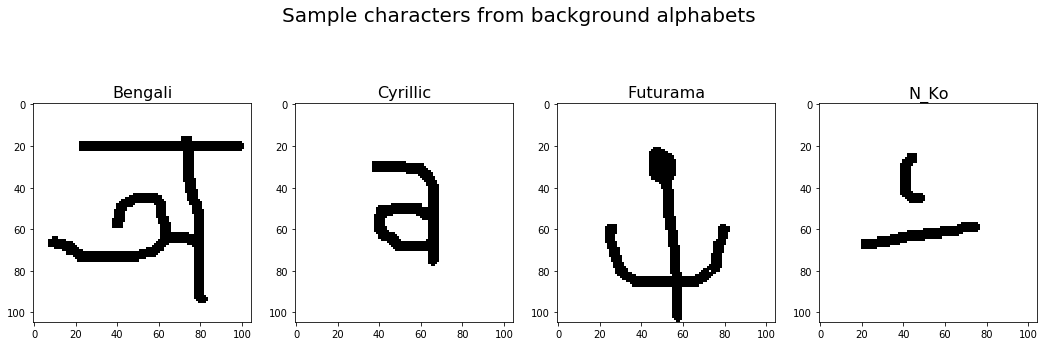

In [45]:
list_of_sample_images = ['data/images_background/Bengali/character01/0132_01.png',
                        'data/images_background/Cyrillic/character01/0218_01.png',
                        'data/images_background/Futurama/character01/0325_01.png',
                        'data/images_background/N_Ko/character08/0811_01.png']
sample_alphabets = ['Bengali', 'Cyrillic', 'Futurama', 'N_Ko']
    
imgs = [mpimg.imread(image_path) for image_path in list_of_sample_images]
fig1 = plt.figure(figsize = (18, 6))
fig1.suptitle('Sample characters from background alphabets', fontsize = 20)
for n, (img, alphabet) in enumerate(zip(imgs, sample_alphabets)):
    a = fig1.add_subplot(1, 4, n+1)
    a.set_title(alphabet, fontsize = 16)
    plt.imshow(img, cmap = 'gray')
plt.show()

Each image is a 105 x 105 pixel, grayscale representation of a single character. The alphabets range from actual alphabets from around the world, such as the Greek and Cyrillic alphabets, to fictional alphabets like the Futurama and Klingon alphabets.

An example of all 20 hand-drawn images of a single character from the Futurama alphabet can be seen below.

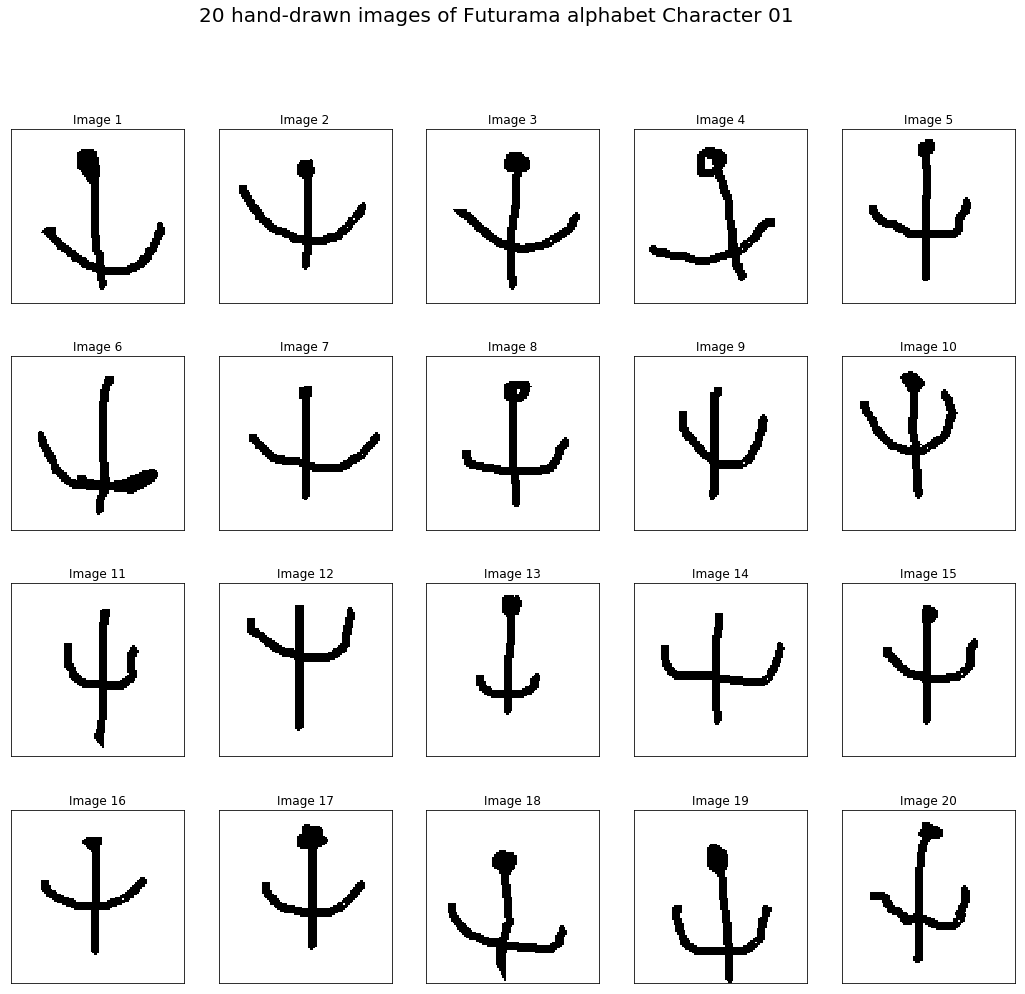

In [49]:
futurama_sample_path = glob('data/images_background/Futurama/character01/*')
imgs = [mpimg.imread(futurama_image) for futurama_image in futurama_sample_path]
fig2 = plt.figure(figsize = (18, 16))
fig2.suptitle('20 hand-drawn images of Futurama Character 01', fontsize = 20)
for n, img in enumerate(imgs):
    a = fig2.add_subplot(4, 5, n+1)
    a.set_title('Image ' + str(n+1))
    a.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    plt.imshow(img, cmap = 'gray')
plt.show()

There is a considerable amount of noise induced by the individual drawers. It is clear from most of the above images that this character is supposed to be more or less symmetrical about the Y axis, as can be seen in Image 13, 16, and 17. However, we can see in Image 6 and Image 18 that the hand drawn images deviate from the actual character structure due to human error. 

This noise, which is unavoidable when it comes to hand drawn characters because humans are inherently imperfect, may make it more difficult for our network to properly learn the best feature embeddings. By exhaustively creating all possible positive pairs (images of the same character) and using them during training, our network will hopefully learn to ignore most of the noise and still produce similar embeddings for matching characters even when they look different, such as Image 11 and Image 17.

## Data Preparation

The character images must be paired up to work with the Siamese network. We will use an even ratio of positive (matching) and negative (non-matching) character image pairs in each of our mini-batches during training. 

The number of unique characters, and therefore the number of unique matching pairs, varies across alphabets, as can be seen below. The number of matching image pairs that can be constructed from a single character C is `(20 choose 2)`. The number of unique matching pairs that can be created from an alphabet is therefore `m * (20 choose 2)` where m = the number of characters in that alphabet. The total number of unique positive pairs that can be built from the background data is 183160. 
  
We can create more unique negative pairs than unique positive pairs. Rather than creating all possible negative pairs, we will use a subset of ~500,000 randomly generated negative pairs.

Due to the number of pairs we will be creating, this analysis was carried out using a [Paperspace](https://www.paperspace.com/) GPU instance with 30GB RAM, making it easy to load all the data directly into memory rather than pickling batches of data or using a Keras Generator.

In [57]:
alphabet_characters = {}
alphabets = glob('data/images_background/*')
for alphabet in alphabets:
    characters = glob(alphabet + '/*')
    char_count = len(characters)
    alphabet_characters[alphabet.split('/')[2]] = char_count
print("{:<45} {:<20} {:<10}".format('Alphabet', 
                                     'Unique Characters', 
                                     'Unique Matching Pairs'))
print('-' * 90)
total_pos_pair_combs = 0
for key, value in sorted(alphabet_characters.items(), 
                         key = lambda kv: (kv[1], kv[0])):
    unique_comb = int(value * comb(20, 2))
    total_pos_pair_combs += unique_comb
    print("{:<45} {:<20} {:<10}".format(key, value, unique_comb))
    
print('\nTotal unique positive pairs from background data: {}'.format(total_pos_pair_combs))

Alphabet                                      Unique Characters    Unique Matching Pairs
------------------------------------------------------------------------------------------
Blackfoot_(Canadian_Aboriginal_Syllabics)     14                   2660      
Ojibwe_(Canadian_Aboriginal_Syllabics)        14                   2660      
Inuktitut_(Canadian_Aboriginal_Syllabics)     16                   3040      
Tagalog                                       17                   3230      
Alphabet_of_the_Magi                          20                   3800      
Early_Aramaic                                 22                   4180      
Hebrew                                        22                   4180      
Syriac_(Estrangelo)                           23                   4370      
Balinese                                      24                   4560      
Greek                                         24                   4560      
Arcadian                                

## Model Architecture

We will be using the Keras library to build the Siamese network. Rather than trying to design the model architecture from scratch, we will implement the Siamese CNN architecture from the [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) paper due to the success the authors had implementing their model to perform 20-way one-shot classification with the Omniglot data.

A single leg of the CNN consists of a series of 2D convolutions with filters of varying size and a fixed stride of 1. The number of convolutional filters is specified as a multiple of 16 to optimize memory performance. The network applies a ReLU activation function to the output feature maps, optionally followed by max-pooling with a filter size and stride of 2. The output of the final convolutional layer is flattened into a single vector. At this point the two individual legs are joined using the flattened vectors from each leg to compute the L1 Siamese distance between the two twins. The L1 distance is then given to a single sigmoid output unit which produces the final output, a number between 0 and 1 indicating the similarity between the two input images. A single leg of the model can be seen below.

![image.png](images/cnn_architecture.png)

The weights and biases of the various layers are initialized as they are in the [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). The weights of the convolution layers are drawn from a normal distribution with zero-mean and standard deviation 0.01. The biases are drawn from a standard normal with a mean 0.5 and standard deviation 0.01. In the fully connected layer, the biases were initialized in the same way as the convolution layers, but the weights were drawn from a wider normal distribution with zero-mean and standard deviation 0.2.

Given that the model is performing binary classification, we use the standard binary cross entropy loss when compiling the model. Initially the model was trained using Stochastic Gradient Descent (SGD) optimization, but the validation loss started to flatline much sooner than when using Adam optimization. The learning rate was chosen via trial and error by monitoring the rate of decrease of the loss for various learning rate values. The final model has a total of 38,951,745 trainable parameters.

In [ ]:
import numpy as np
from itertools import combinations
import keras
import tensorflow as tf
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Flatten, Lambda, merge, Input, Concatenate, Conv2D, MaxPooling2D
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.core import LambdaMerge
#from keras.models import Sequential
from keras.initializers import RandomNormal
from scipy.special import comb

In [25]:
input_shape = (105, 105, 1)

# Weight & Bias initializer 
def wb_init(mean = 0.0, sd = 1e-2):
    return RandomNormal(mean, sd)

# Assign inputs for each leg of the siamese network
s1_input = Input(input_shape)
s2_input = Input(input_shape)

# Build a single leg
cnn = Sequential()
cnn.add(Conv2D(64, 10, 
               activation = 'relu', 
               input_shape = input_shape, 
               kernel_initializer = wb_init(0, 1e-2), 
               bias_initializer = wb_init(0.5, 1e-2), 
               kernel_regularizer = l2(2e-4)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, 7, 
               activation = 'relu', 
               kernel_initializer = wb_init(0, 1e-2), 
               bias_initializer = wb_init(0.5, 1e-2), 
               kernel_regularizer = l2(2e-4)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, 4,
              activation = 'relu',
              kernel_initializer = wb_init(0, 1e-2),
              bias_initializer = wb_init(0.5, 1e-2),
              kernel_regularizer = l2(2e-4)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(256, 4,
              activation = 'relu',
              kernel_initializer = wb_init(0, 1e-2),
              bias_initializer = wb_init(0.5, 1e-2),
              kernel_regularizer = l2(2e-4)))
cnn.add(Flatten())
cnn.add(Dense(4096,
             activation = 'sigmoid',
             kernel_initializer = wb_init(0, 2e-1),
             bias_initializer = wb_init(0.5, 1e-2),
             kernel_regularizer = l2(1e-3)))

# Encode each input image into a vactor
s1_encoded = cnn(s1_input)
s2_encoded = cnn(s2_input)

# Compute L1-distance between the encodings
l1_distance_layer = Lambda(lambda x:K.abs(x[0] - x[1]))
l1_distance = l1_distance_layer([s1_encoded, s2_encoded])

# predict whether the two input images are form the same alphabet
output = Dense(1, activation = 'sigmoid',
                  bias_initializer = wb_init(0.5, 1e-2))(l1_distance)

# create model and display summary
siamese = Model(inputs = [s1_input, s2_input], outputs = output)
siamese.summary()

# set up the optimizer
#optimizer = SGD(lr = 0.01, momentum = 0.5, nesterov = True, decay = 0.0003)
optimizer = Adam(lr = 0.00006)

# compile the model
siamese.compile(loss = 'binary_crossentropy', optimizer = optimizer)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

38951745

## Training and Evaluation

In addition to monitoring the cross entropy loss, we also intermittently monitor intra-alphabet 20-way one-shot learning accuracy across 400 one-shot learning tasks from the evaluation data. The 20-way one shot learning is once again inspired by the work of [Koch et al](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf), with one minor alteration: the authors perform **40** one-shot learning classifications for each of the **10** alphabets in their evaluation data, resulting in 400 one-shot learning trials. Here we perform **20** one-shot learning classification tasks for each of the **20** alphabets in the evaluation data, also resulting in 400 one-shot learning trials, from which the classification accuracy in calculated.

The Siamese_loader class handles all the data preparation, building of positive and negative pairs, generation of minibatches, and 20-way one-shot learning evaluations.
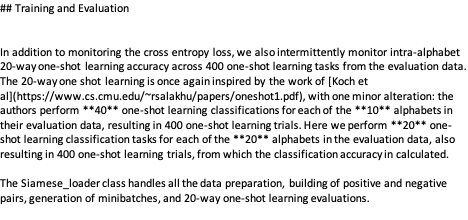

In [22]:
class Siamese_loader:
    
    def __init__(self, data_path):
        """
        Initialize siamese loader with necessary data
        
        Parameters
        ----------
        
            data_path: string
            
                path to the datasets
        
        """
        
        train_data_path = data_path + '/images_background'
        eval_data_path = data_path + '/images_evaluation'
        self.train_alphabet_dict = self.create_alph_dict(train_data_path)
        self.eval_alphabet_dict = self.create_alph_dict(eval_data_path)
        self.pos_pairs = self.create_positive_pairs(self.train_alphabet_dict)
        self.neg_pairs = self.create_negative_pairs(self.train_alphabet_dict)

    
    ######################## new stuff ######################################
    
    
    def create_positive_pairs(self, alph_dict):
        """
        Builds positive pairs of intra-alphabet characters across
        all the alphabets in the input dictionary.
        
        Parameters
        ----------
        
            alph_dict: dictionary
            
                Dictionary containing alphabets, characters, and
                images from which the pairs are built.
                
        Returns
        -------
        
            positive_pairs: list
            
                List of positive pairs, each pair consisting of
                two (105 x 105 x 1) images
        
        """
        
        print('Building and loading positive pairs...')
        
        positive_pairs = []
        
        # loop over each alphabet
        for alphabet in alph_dict.values():
            
            # loop over each character
            for character in alphabet.values():
                
                # all images of current character
                list_of_images = list(character.values())
                
                # all unique pairs of current character in current alphabet
                unique_pairs = list(combinations(list_of_images, 2))
                
                positive_pairs.extend(unique_pairs)
        
        # shuffle data
        np.random.shuffle(positive_pairs)
        
        return positive_pairs

    
    
    def create_negative_pairs(self, alph_dict):
        """
        Builds negative pairs of intra-alphabet characters across
        all the alphabets in the input dictionary.
        
        Parameters
        ----------
        
            alph_dict: dictionary
            
                Dictionary containing alphabets, characters, and
                images from which the pairs are built.
                
        Returns
        -------
        
            negative_pairs: list
            
                List of negative pairs, each pair consisting of
                two (105 x 105 x 1) images
        
        """
        
        print('Building and loading negative pairs...')
        
        negative_pairs = []
        
        # loop over each alphabet
        for alph_key, alphabet in alph_dict.items():
            
            #print('Currently working on {}'.format(alph_key))
            
            # loop over characters to get anchor images
            for char_1_key, character_1 in alphabet.items():
                
                # shuffeled list of all images for anchor image
                anchor_image_list = list(character_1.values())
                np.random.shuffle(anchor_image_list)
                
                # loop over characters to get pair images
                for char_2_key, character_2 in alphabet.items():
                    
                    # only build pairs of different intra-alphabet characters
                    if not char_1_key == char_2_key:
                        
                        # shuffeled list of images for pair image
                        pair_image_list = list(character_2.values())
                        np.random.shuffle(pair_image_list)
                        
                        # choose 15 random images from each list
                        rand_indicies = list(np.random.choice(list(range(20)), 
                                                                   15, 
                                                                   replace = False))
                        
                        pairs = [[anchor_image_list[i], 
                                  pair_image_list[i]] for i in rand_indicies]
                        
                        # add pairs to list
                        negative_pairs.extend(pairs)
        
        # shuffle data
        np.random.shuffle(negative_pairs)
        
        return negative_pairs
        

    def create_alph_dict(self, dr = '.'):
        """
        Builds a twice-nested dictionary using alphabet names as keys
        and character dictionaries as values. Nested character dictionary 
        uses character numbers as keys, and image dictionaries as 
        values. Image dictionary uses image numbers as key and image vactor
        as values.

        Parameters
        ----------

        dr: string

            A path to a directory containing alphabet folders

        Returns
        -------

            alph_dict: dictionary

                A dictionary containing a nested dictionary of characters for each
                alphabet in the specified directory.

        """    
        print('Building alphabet dictionary from {}...'.format(dr))
 
        alph_dict = {}

        # the paths to the background alphabets for training
        alphabets = glob(dr + '/*')
        
        # loop over each alphabet and build the corresponding character dictionary
        for alphabet in alphabets:

            # the path to the inividual character folders of the current alphabet
            characters = glob(alphabet + '/*')

            char_dict = {}

            # loop over each character folder and build the corresponding image dictionary
            for character in characters:

                # the paths to the individual images
                images = glob(character + '/*')

                img_dict = {}

                # loop over each image of the current character and add it to the dictionary
                for image_file in images:

                    # the dictionary key for the current image
                    split_img_name = image_file.split('/')
                    img_key = split_img_name[len(split_img_name) - 1]

                    # read image from file and add dictionary
                    img_2d = mpimg.imread(image_file)
                    img_3d = np.expand_dims(img_2d, axis = 2)
                    img_dict[img_key] = img_3d


                # dictionary key for the current character
                split_char_name = character.split('/')
                char_key = split_char_name[len(split_char_name) - 1]

                # add image dictionary to the character dictionary
                char_dict[char_key] = img_dict


            # dictionary key for the current alphabet
            split_alph_name = alphabet.split('/')
            alph_key = split_alph_name[len(split_alph_name) - 1]

            # add character dictionary to the alphabet dictionary
            alph_dict[alph_key] = char_dict

        # return the alphabet dictionary
        return alph_dict

    
    def get_batch(self, batch_size, starting_index):
        """
        Gets a training batch of size batch_size,
        equal proportions positive and negative pairs.

        Parameters
        ----------

            batch_size: int

                the size of the training batch
                
            starting_index: int
            
                index indicating where in the pos_pairs and neg_pairs
                list to take the subset of data for the batch, insures
                all positive and negative pairs are used during training

        Returns
        -------

            batch_features: numpy array

                array of image pairs

            batch_lables: numpy array

                array of labels for the corresponding features

        """

        batch_features = np.zeros((batch_size, 2, 105, 105, 1))
        batch_labels = np.zeros((batch_size,1))
        
        # different number of pos and neg examples
        pos_length = len(self.pos_pairs)
        neg_length = len(self.neg_pairs)
        
        # build batch
        for i in range(batch_size):
            
            # alternate between positive and negative pairs
            if i % 2 == 0:
                if starting_index + i + 1 >= pos_length:
                    batch_features[i] = self.pos_pairs[(starting_index + i) % pos_length]
                else:
                    batch_features[i] = self.pos_pairs[starting_index + i]
                batch_labels[i] = 1
            else:
                if starting_index + i + 1 >= neg_length:
                    batch_features[i] = self.neg_pairs[(starting_index + i) % neg_length]
                else:
                    batch_features[i] = self.neg_pairs[starting_index + i]
                batch_labels[i] = 0

        return batch_features, batch_labels 
    
    
    def get_20_imgs(self, alphabet, drawer_1, drawer_2):
        """
        Builds two arrays of 20 random character images, each array
        containing images from a spicific drawer.
        
        Parameters
        ----------

            alphabet: dictionary

                the alphabet dictionary
                
            drawer_1: int
            
                index corresponding to a specific drawer
                
            drawer_2: int
            
                index corresponding to a specific drawer

        Returns
        -------

            imgs_1: list
            
                images from drawer_1
                
            imgs_2: list
            
                images from drawer_2
        
        """
        
        # get the character dictionary for the specified alphabet
        char_dict = self.eval_alphabet_dict[alphabet]
        
        chars = list(char_dict.keys())
        num_chars = len(chars)
        
        # select 20 random characters from the alphabet
        rand_chars = [chars[i] for i in list(np.random.choice(num_chars,
                                                             20,
                                                             replace = False))]
        imgs_1, imgs_2 = [], []
        
        # get image of each random character for each of the two drawers
        for char in rand_chars:
            
            # get image dict and sort keys
            image_dict = char_dict[char]
            image_keys = list(image_dict.keys())
            image_keys.sort()
            
            # get two drawers' images by index
            imgs_1.append(image_dict[image_keys[drawer_1]])
            imgs_2.append(image_dict[image_keys[drawer_2]])
        
        imgs_1 = np.asarray(imgs_1)
        imgs_2 = np.asarray(imgs_2)
        
        return imgs_1, imgs_2
    
    
    def build_20_tests(self, imgs_1, imgs_2):
        """
        Builds numpy array containing 20 sets of 20-way images
        used to test 20-way one shot classification
        
        Parameters
        ----------
        
            imgs_1: list 
            
                list of character images from 1 alphabet all drawn by
                the same drawer, considered the 'test' image
                
            imgs_2: list
            
                list of character images from 1 alphabet all drawn by
                the same drawer, considered the labeled images to test
                against
        
        """
        
        # shape: 20 sets of 2 arrays containing 20 (105 x 105 x 1) images respectively
        pair_arrays = np.empty((20, 2, 20, 105, 105, 1))
        
        for i in range(20):
            
            # first col is all same images
            first_col = np.stack([imgs_1[i] for j in range(20)])
            
            second_col = imgs_2
            
            pair_arrays[i] = [first_col, second_col]
            
        return pair_arrays
    
    def plot_single_test(pairs):
        """
        Plots the images in a single 20-way one-shot test

        Parameters
        ----------

            pairs: 
                a pair of 20 x 105 x 105 x 1 test images, 
                first column anchor images are all the same, 
                second column test images are all different, 
                shape (2 x 20 x 105 x 105 x 1)
        """

        fig = plt.figure(figsize = (15, 40))

        for i in range(1, (len(pairs[0]) + 1)): #1 - 20

            a = fig3.add_subplot(20, 2, i*2-1)
            a.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
            plt.imshow(pairs[0][i - 1][:,:,0], cmap = 'gray')

            a = fig3.add_subplot(20, 2, i*2)
            a.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
            plt.imshow(pairs[1][i - 1][:,:,0], cmap = 'gray')

        plt.show()
    
    
    def test_one_shot(self, model, drawer_1, drawer_2, verbose = False):
        """
        Tests models accuracy across 400 20-way one-shot classificaiton tasks
        
        Parameters
        ----------
        
            model: Keras model
                
                The siamese model
                
            drawer_1: int
                
                Index indicating which drawer to use for test images
                
            drawer_2: int
            
                Index indication which drawer to use as labeled images
                to test agains
                
            verbose: boolean
            
                Indicates whether or not to print resulting accuracy
        
        """

        num_correct = 0
        
        # list of evaluation alphabets
        eval_alphs = list(self.eval_alphabet_dict.keys())

        if verbose:
            print('Evaluating model on 400 20-way one-shot learning tasks..')
        
        # loop over each alphabet in the evaluation data
        for alphabet in eval_alphs:

            imgs_1, imgs_2 = self.get_20_imgs(alphabet, drawer_1, drawer_2)

            one_shot_tests = self.build_20_tests(imgs_1, imgs_2)

            for n, test in enumerate(one_shot_tests):
                
                # predict
                prob = model.predict([test[0], test[1]])
             
                if np.argmax(prob) == n:

                    num_correct += 1
                    
        # calculate accuracy
        one_shot_accuracy = (num_correct / 400 * 100.0)
        
        if verbose:
            print('Model averaged {}% accuracy on {} 20-way one-shot classification tasks'.format(one_shot_accuracy, 
                                                                                                  num_tests))
        
        return one_shot_accuracy
    
# create loader with necessary data
loader = Siamese_loader('./data')
print('Loader ready!')

## The Training Loop

We us batches of 128 pairs, once again inspired by [Koch at al](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) and train the model for 30000 iterations, or until we notice the learning curve flatten out, while continuously monitoring the 20-way one-shot classification accuracy.

In [ ]:
evaluate_every = 500
loss_every = 100
batch_size = 128
num_iterations = 30000

# two random drawers for checking 20-way classificaiotn accuracy
drawer_1 = np.random.randint(20)
drawer_2 = np.random.randint(20)

# make sure drawers for 20-way test are different
while drawer_1 == drawer_2:
    drawer_2 = np.random.randint(20)
#     
starting_batch_index = 0

best = -1.0

# create folder to save model if it doesnt exist
if not os.path.exists('./model'):
    os.makedirs('./model')
    
# load model if it exists and update best accuracy
if os.path.exists('./model/siamese.h5'):
    print('Loading model and updating best...')
    siamese = load_model('./model/siamese.h5')
    best = loader.test_one_shot(siamese, drawer_1, drawer_2, verbose = False)
    print('Current model 20-way classification accuracy: {}'.format(best))

# training loop
for i in range(num_iterations):
    
    # get batch and train
    (inputs, targets) = loader.get_batch(batch_size, starting_batch_index)
    loss = siamese.train_on_batch([inputs[:,0], inputs[:,1]], targets)
    starting_batch_index += batch_size
    
    # check 20-way accuracy on validation data
    if i % evaluate_every == 0:
        eval_acc = loader.test_one_shot(siamese, drawer_1, drawer_2, verbose = True)
        if eval_acc > best:
            print("Improved 20-way classification accuracy, saving model.")
            siamese.save('./model/siamese.h5')
            best = eval_acc
            
    # print current model loss every loss_every iteration
    if i % loss_every == 0:
        print('Iteration {}, training loss: {:.3f}'.format(i, loss))

## Results

During training we monitored 20-way one-shot classification accuracy across 400 one-shot tasks, always using the same two drawers. The models highest 20-way classification accuracy was **69.0%** The drawers, however, were chosen at random. As we saw earlier when examining Futurama characters, some drawers do a better job of adhering to the actual character structure than others. To see how the different drawing styles impact the 20-way classification accuracy, we used the best version of the model from the training loop and evaluated it on 400 20-way classification tasks from all possible drawer combinations. The highest 20-way classification accuracy was **72.5%**, while the lowest accuracy was **59.0%**.

In [44]:
from tabulate import tabulate

# load best model
siamese = load_model('./model/siamese.h5')

table_data = np.zeros((20,20))

# keep track of best and worst accuracy
highest = 0.0
lowest = 100.0

drawer_combinations = combinations(list(range(20)), 2)

# evaluate all combinations, this takes a while
for drawers in drawer_combinations:
    accuracy = loader.test_one_shot(siamese, drawers[0], drawers[1], verbose = False)
    table_data[drawers[0]][drawers[1]] = round(accuracy, 2)
    if accuracy < lowest:
        lowest = accuracy
    if accuracy > highest:
        highest = accuracy

# table doesn't fit well when printed
#headers = list(range(1,21))
#rowIDs = list(range(1,21))
#print(tabulate(table_data, headers = headers, showindex=rowIDs))

print('Best 20-way classification accuracy: {}'.format(highest))
print('Worst 20-way classification accuracy: {}'.format(lowest))

Best 20-way classification accuracy: 72.5
Worst 20-way classification accuracy: 59.0


## Next Steps

The [Koch at al](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) authors implement random affine distortions during the training process. Keras has a number of tools in the ImageGeneratorClass that may help us make these distortions to the data. The authors observe that the affine distortions improve the accuracy on the evaluation data by ~2.0%. The authors also make use of layer-wise learning rates and learning rate annealing, which could improve the speed of convergence to local minima without getting stuck in the error surface.

One of the flaws in our 20-way one-shot classification approach is that our training and classification objectives are different. During training, the model is exposed to two images at a time. During classification, however, we expect the model to distinguish between 20 test images by showing the model one test pairs at a time rather than being exposed to all 20 images simultaneously. The model may perform better if we can compare the anchor image to the test set as a whole. This would allow us to implement restrictions that only one of the 20 images in the test set is of the same class as the anchor image. When our model predicts on a set of 20 images, we observe that many of the probabilities in the output vector are very similar, making it more dificult to properly classify the images. Building a nearest neighbor classifier end to end, such as [Matching Networks for One Shot Learning](https://arxiv.org/pdf/1606.04080.pdf), would reduce the confusion between similar images in the test set. 
